# Quantum Optimal Control with Diffrax + AutoFD

https://arxiv.org/pdf/2010.09368

In [1]:
import diffrax
import equinox as eqx
import optax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dt0 = None
t0 = 0
T = 1
psi0 = jnp.array([[1],[0],[0]],dtype=complex)
psif = jnp.array([[0],[0],[1]],dtype=complex)

In [3]:
class QControl(eqx.Module):
  # TODO 1 some mechanism of parametrizing the controls
  # TODO 2 functional derivatives
  omega_1: float # TODO make jax array
  omega_2: float
  amp_1: float
  amp_2: float

  def ctrl1(self, t):
    return self.amp_1*jnp.sin(t*self.omega_1)
  def ctrl2(self, t):
    return self.amp_2*jnp.sin(t*self.omega_2)
  def __call__(self, t, y, args):
    E = jnp.array([1,1.5,2],dtype=complex)
    H0 = jnp.diagflat(E)
    DE01 = E[1]-E[0]
    DE12 = E[2]-E[1]
    u1 = self.ctrl1(t)
    u2 = self.ctrl2(t)
    Omega_1 = 1j*t*DE01
    Omega_2 = 1j*t*DE12
    H1 = jnp.array([
      [0,jnp.exp(Omega_1),0],
      [jnp.exp(-Omega_1),0,0],
      [0,0,0]
      ],dtype=complex
    )
    H2 = jnp.array([
      [0,0,0],
      [0,0,jnp.exp(Omega_2)],
      [0,jnp.exp(-Omega_2),0]
    ],dtype=complex)
    H = H0 + u1*H1 + u2*H2
    return (-1j*H) @ y


In [4]:
dx_solver = diffrax.Tsit5()
dx_controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)
dx_adjoint = diffrax.RecursiveCheckpointAdjoint()

In [5]:
def loss(c_model, c_target):
    sol = diffrax.diffeqsolve(
        terms=diffrax.ODETerm(c_model),
        solver=dx_solver,
        t0=t0,
        t1=T,
        dt0=dt0,
        y0=psi0,
        max_steps=1000000,
        stepsize_controller=dx_controller,
        adjoint=dx_adjoint,
    )
    
    (y1,) = sol.ys
    k = .01
    return ((1 - (jnp.abs(y1.T@c_target)[0,0])**2)  
            # + k * ( 
            #     (c_model.amp_1**2)*(T/2 + jnp.sin(2*T*jnp.abs(c_model.omega_1))/jnp.abs(c_model.omega_1*4)) +
            #     (c_model.amp_2**2)*(T/2 + jnp.sin(2*T*jnp.abs(c_model.omega_2))/jnp.abs(c_model.omega_2*4))
            #     )
            )

In [6]:
model = QControl(
        omega_1=jnp.array(5.0),
        omega_2=jnp.array(1.0),
        amp_1=jnp.array(5.0),
        amp_2=jnp.array(1.0),
    )
# optim = optax.adam(learning_rate=1e-1)# ,momentum=.7, nesterov=True)
optim = optax.adam(1e-1)
opt_state = optim.init(model)


@eqx.filter_jit
def make_step(model, opt_state, target):
    loss_val, grads = eqx.filter_value_and_grad(loss)(model, target)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val


for step in range(50):
    model, opt_state, loss_val = make_step(model, opt_state, psif)
    print(f"Step: {step} Loss: {loss_val}")
print(f"Target: {psif}")

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


Step: 0 Loss: 0.8442939519882202


/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


Step: 1 Loss: 0.7821667194366455
Step: 2 Loss: 0.709758460521698
Step: 3 Loss: 0.6294301748275757
Step: 4 Loss: 0.543023943901062
Step: 5 Loss: 0.4530901312828064
Step: 6 Loss: 0.3650732636451721
Step: 7 Loss: 0.282718300819397
Step: 8 Loss: 0.20845437049865723
Step: 9 Loss: 0.14499998092651367
Step: 10 Loss: 0.09465503692626953
Step: 11 Loss: 0.05661332607269287
Step: 12 Loss: 0.029370903968811035
Step: 13 Loss: 0.012086987495422363
Step: 14 Loss: 0.002788722515106201
Step: 15 Loss: -0.0008661746978759766
Step: 16 Loss: -0.000532984733581543
Step: 17 Loss: 0.0025541186332702637
Step: 18 Loss: 0.006602108478546143
Step: 19 Loss: 0.010333776473999023
Step: 20 Loss: 0.013166546821594238
Step: 21 Loss: 0.014554321765899658
Step: 22 Loss: 0.014057934284210205
Step: 23 Loss: 0.011813938617706299
Step: 24 Loss: 0.008444070816040039
Step: 25 Loss: 0.004679560661315918
Step: 26 Loss: 0.0013329386711120605
Step: 27 Loss: -0.0008035898208618164
Step: 28 Loss: -0.001212477684020996
Step: 29 Loss:

## Show Final Control

In [9]:
final_model = QControl(
  omega_1=model.omega_1,
  omega_2=model.omega_2,
  amp_1=model.amp_1,
  amp_2=model.amp_2
)
ts = jnp.linspace(t0,T,100)
final_sim = diffrax.diffeqsolve(
  terms=diffrax.ODETerm(final_model),
  solver=dx_solver,
  t0=t0,
  t1=T,
  dt0=dt0,
  y0=psi0,
  max_steps=None,
  stepsize_controller=dx_controller,
  adjoint=dx_adjoint,
  saveat=diffrax.SaveAt(ts=ts)
)
final_ys = final_sim.ys
final_loss = loss(final_model, psif)


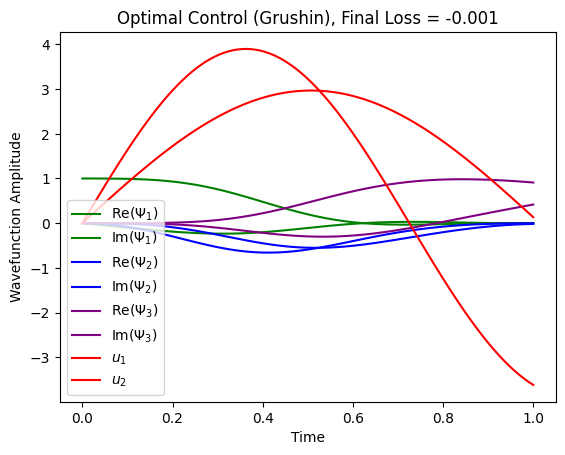

In [10]:
plt.plot(ts,jnp.real(final_ys[:,0]),label=r"$\text{Re}(\Psi_1)$",color="green")
plt.plot(ts,jnp.imag(final_ys[:,0]),label=r"$\text{Im}(\Psi_1)$",color="green")
plt.plot(ts,jnp.real(final_ys[:,1]),label=r"$\text{Re}(\Psi_2)$",color="blue")
plt.plot(ts,jnp.imag(final_ys[:,1]),label=r"$\text{Im}(\Psi_2)$",color="blue")
plt.plot(ts,jnp.real(final_ys[:,2]),label=r"$\text{Re}(\Psi_3)$",color="purple")
plt.plot(ts,jnp.imag(final_ys[:,2]),label=r"$\text{Im}(\Psi_3)$",color="purple")


plt.plot(ts,jnp.real(final_model.ctrl1(ts)),label=r"$u_1$",color="red")
plt.plot(ts,jnp.real(final_model.ctrl2(ts)),label=r"$u_2$",color="red")
plt.xlabel("Time")
plt.ylabel("Wavefunction Amplitude")
plt.legend()
plt.title(f"Optimal Control (Grushin), Final Loss = {np.round(float(final_loss),3)}")
plt.show()